In [1]:
import pickle; import tensorflow as tf; import pandas as pd
import matplotlib.pyplot as plt ; import datetime; from datetime import datetime
#print(tf.version)
import bz2; import random; import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import warnings; from sklearn import metrics
import seaborn as sns; import itertools
warnings.filterwarnings('ignore')
###
import os; import os.path; from glob import glob
import random; import shutil
from tqdm.auto import tqdm
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
#from kerashypetune import KerasGridSearch
from numpy import mean; from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import eigh; import plotly.express as px; 

In [2]:
def FIPS_function(row):
    state = str(row['stateFip']).zfill(2)
    county = str(row['countyFip']).zfill(3)
    return str(state + county)


def get_above_threshold_2(dff,target,thresh):
    
    corr_mtrx = dff.corr(); corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns); numCols = corr_mtrx.shape[0]
    
    above_threshold = []
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] > thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    
    #above = [above.append(i) for i in above_threshold if i[0] == target or if i[1] == target:]
    list_above = []
    for i in above_threshold:
        if i[0] == target or i[1] == target:
            list_above.append(i)
            
    return corr_mtrx, list_above


def get_suggestions(dff,num,methodd):
    
    # get correlation matrix using desired method
    og_corr_mtrx = dff.corr(method=methodd); corr_vals = og_corr_mtrx.values
    flds = list(og_corr_mtrx.columns); numCols = og_corr_mtrx.shape[0]; 
    target_corrs = []; target = 'JHU_ConfirmedCases.data'
    
    # iterate throughout matrix and get all correlations associated with target
    for i in range(numCols):
        for j in range(i+1, numCols):
            if i != j:
                if flds[i] == target or flds[j] == target:
                    target_corrs.append([flds[i],flds[j],corr_vals[i,j]])
    
    # convert corrs to df, sort by correlations and keep only the number of desried rows 
    s_corrs = pd.DataFrame(target_corrs,columns=['col1','col2','corr'])
    s_corrs = s_corrs.sort_values(by='corr', ascending=False).head(num)
    s_corrs.reset_index(drop=True); suggestion_lst=[]
    
    # put the names of columns into a list
    for i, j in s_corrs.iterrows():
        if j["col1"] != target:
            suggestion_lst.append(j['col1'])
        if j['col2'] != target:
            suggestion_lst.append(j['col2'])
            
    return suggestion_lst, s_corrs, og_corr_mtrx

In [11]:
file_name = '/Users/evanfalkowski/Documents/Drexel/Capstone/DSCI_592/workspace/feeFiFoFum.pbz2'
bz_file = bz2.BZ2File(file_name,'rb'); df = pd.read_pickle(bz_file)
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']
df.drop(cols, axis=1, inplace=True); print(df.shape); df.head(3)

(1879589, 88)


,dates,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,...,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25
0,2020-03-19,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
1,2020-03-20,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
2,2020-03-21,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551


In [12]:
print(df.shape,df.isnull().sum().sum())
df = df.dropna(); df = df.reset_index(drop = True);df = df.drop(columns='dates')
print(df.shape,df.isnull().sum().sum())

(1879589, 88) 380
(1879209, 87) 0


## PCA
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- at 95% variance

In [36]:
target = 'JHU_ConfirmedCases.data'; features = list(df.columns);y = df.loc[:,[target]].values
x = df.loc[:, features].values; x = StandardScaler().fit_transform(x)

pca = PCA(); principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

pca_df = pd.concat([principalDf, df[[target]]], axis = 1)
var_expln = list(pca.explained_variance_ratio_);var_expln.sort(reverse=True)
print('Number of principle compnents: ', len(var_expln))
print('Original number of compnents: ', df.shape[1])

Number of principle compnents:  87
Original number of compnents:  87


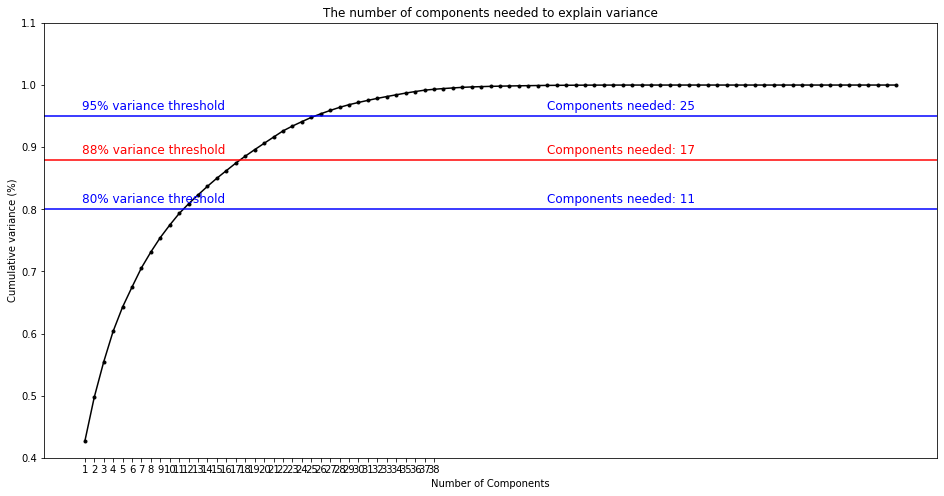

In [37]:
# Plot the cumulative variance for each component
#https://statisticallyrelevant.com/principal-component-analysis-in-python/
plt.figure(figsize = (16, 8))
components = np.arange(1, 88, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.4,1.1)
plt.plot(components, variance, marker='.', linestyle='-', color='black')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 39, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
#95%
plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(0.75, 0.96, '95% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.96, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]), color = "blue", fontsize=12)
#90%
plt.axhline(y=0.88, color='r', linestyle='-')
plt.text(0.75, 0.89, '88% variance threshold', color = 'red', fontsize=12)
plt.text(50, 0.89, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.88)[0][0]), color = "red", fontsize=12)
#80%
plt.axhline(y=0.80, color='b', linestyle='-')
plt.text(0.75, 0.81, '80% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.81, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.80)[0][0]), color = "blue", fontsize=12)
plt.show()

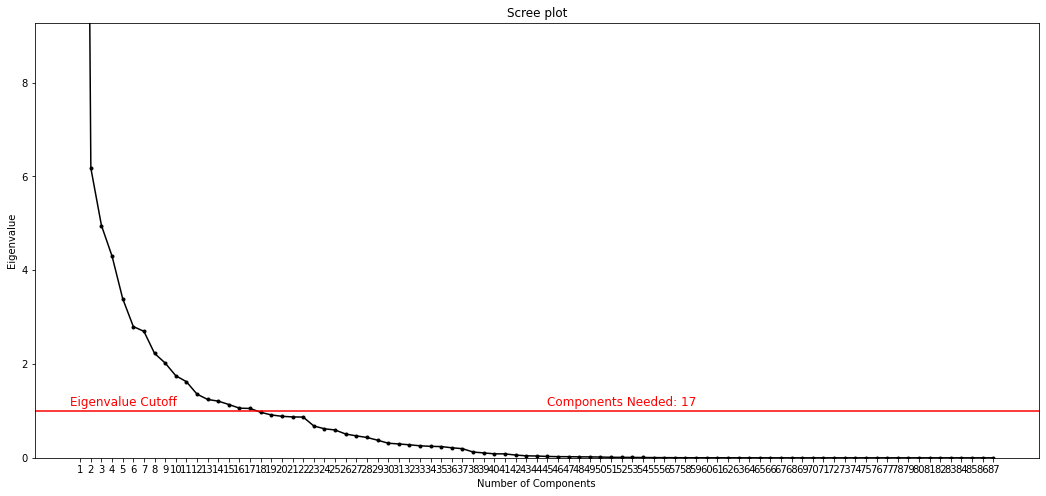

In [39]:
# Scree plot
plt.figure(figsize=(18, 8))
components = np.arange(1, 88, step=1)
eigenvalues = pca.explained_variance_
plt.plot(components, eigenvalues, marker = '.', linestyle = '-', color = 'black')
#plt.ylim(0, max(eigenvalues))
plt.ylim(0, max(eigenvalues)/4)
plt.ylabel('Eigenvalue')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 88, step = 1))
plt.title('Scree plot')
plt.axhline(y=1, color = 'r', linestyle = '-')
plt.text(0, 1.11, 'Eigenvalue Cutoff', color = 'red', fontsize=12)
plt.text(45,1.11,'Components Needed: '+str(np.where(eigenvalues<=1)[0][0]),color='red',fontsize=12)
plt.show()

The above scree plot contains the eigenvalues on the y axis and the number of components 
on the x axis. A general rule of thumb, is to keep number of components that have an 
eigenvalue greater than 1. The scree plot suggests to keep 17 components. 

## Suggestions from correlations and components

#### Pearson

In [42]:
p_suggestions, p_suggestion_df, p_corr_matrx = get_suggestions(df,17,'pearson')
print(p_suggestion_df.head(2));print('---');print(p_suggestion_df.tail(2));print('\n',p_suggestions)

                      col1                         col2      corr
0  JHU_ConfirmedCases.data     JHU_ConfirmedDeaths.data  0.957832
6  JHU_ConfirmedCases.data  BLS_EmployedPopulation.data  0.782552
---
                       col1              col2      corr
76  JHU_ConfirmedCases.data  unitsInStructure  0.763475
66  JHU_ConfirmedCases.data     houseFamily65  0.763316

 ['JHU_ConfirmedDeaths.data', 'BLS_EmployedPopulation.data', 'BLS_LaborForcePopulation.data', 'healthInsTotal', 'totalMoved', 'Female_Total_Population.data', 'TotalPopulation.data', 'latestTotalPopulation', 'Male_Total_Population.data', 'MaleAndFemale_Under18_Population.data', 'totalTrans', 'houseFamilyNo65', 'householdStructuresTotal', 'householdsTotal', 'house2+No65', 'unitsInStructure', 'houseFamily65']


### Other dimensionality techniques
 - #https://towardsdatascience.com/dimensionality-reduction-with-python-d3fac4e57c71
 - #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
 - #https://www.learndatasci.com/tutorials/applied-dimensionality-reduction-techniques-using-python/
 - #https://statisticallyrelevant.com/principal-component-analysis-in-python/

In [22]:
###from above ## try different pca filters

#pca_2 = PCA(n_components=0.99, whiten=True)
#features_pca = pca_2.fit_transform(x_df)

#print("Original number of features:", raw_df.shape[1])
#print("Reduced number of features:", features_pca.shape[1])

In [44]:
X,Y = df[features], df[target]; X = X.drop(target,axis=1)

In [50]:
#### recursive feature elimination
import warnings;from sklearn.feature_selection import RFECV;from sklearn import linear_model

lr = linear_model.LinearRegression()

rfecv = RFECV(estimator=lr, step=1, scoring="neg_mean_squared_error")
rfecv.fit(X,Y)
rfecv.transform(X)

array([[24527.0, 9716.5, 0.0, ..., 39, 122, 2555],
       [24527.0, 9716.5, 0.0, ..., 39, 122, 2555],
       [24527.0, 9716.5, 0.0, ..., 39, 122, 2555],
       ...,
       [2756.0, 978.0, 0.0, ..., 0, 16, 751],
       [2756.0, 978.0, 0.0, ..., 0, 16, 751],
       [2756.0, 978.0, 0.0, ..., 0, 16, 751]], dtype=object)

In [58]:
##https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
print(rfecv); print(rfecv.n_features_, rfecv.n_features_in_)

RFECV(estimator=LinearRegression(), scoring='neg_mean_squared_error')
52 86


In [71]:
### support masks the variable if you should use it or not, masks with true or false
rfecv_suggestion = []
for i in range(rfecv.n_features_in_):
    if rfecv.support_[i] == True:
        rfecv_suggestion.append(rfecv.feature_names_in_[i])
print(len(rfecv_suggestion)); rfecv_suggestion


52


['TotalPopulation.data',
 'BLS_EmployedPopulation.data',
 'BLS_EmployedPopulation.missing',
 'BLS_UnemployedPopulation.data',
 'BLS_UnemployedPopulation.missing',
 'BLS_UnemploymentRate.missing',
 'BLS_LaborForcePopulation.data',
 'BLS_LaborForcePopulation.missing',
 'AverageDewPoint.missing',
 'AverageRelativeHumidity.missing',
 'AverageSurfaceAirPressure.missing',
 'AveragePrecipitationTotal.data',
 'AveragePrecipitationTotal.missing',
 'AveragePrecipitation.missing',
 'AverageWindDirection.missing',
 'AverageWindSpeed.missing',
 'latestTotalPopulation',
 'jhu_daily_cases',
 'jhu_daily_new_cases',
 'jhu_daily_cases_rolling_7',
 'jhu_daily_new_cases_rolling_7',
 'jhu_daily_cases_rolling_30',
 'jhu_daily_new_cases_rolling_30',
 'jhu_death_rate',
 'jhu_case_rate',
 'jhu_new_case_rate',
 'icu_beds_per_person',
 'staffed_beds_per_person',
 'licensed_beds_per_person',
 'cold_days',
 'hot_days',
 'moderate_days',
 'lt_18_percent',
 'employed_percent',
 'householdsTotal',
 'houseWith65',
 'h

In [62]:
### set to pca suggestion number of components
#for i in range(rfecv.n_features_in_):
    #if rfecv.ranking_[i] <= 18:
        #print(rfecv.feature_names_in_[i])

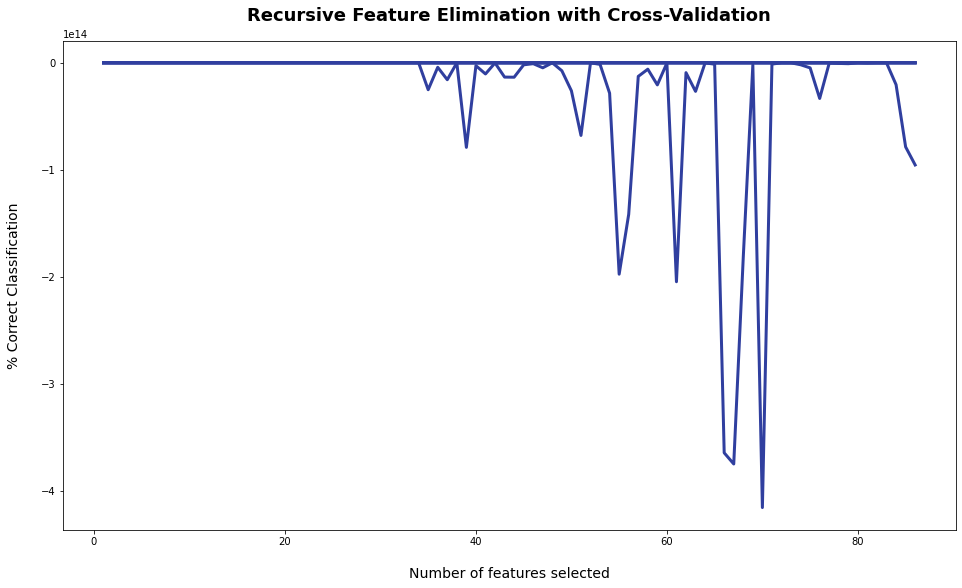

In [55]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [64]:
#print(np.where(rfecv.support_ == False)[0])
#x.drop(x.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

#least important features
for i in range(rfecv.n_features_in_):
    if rfecv.support_[i] == False:
        print(rfecv.feature_names_in_[i])

JHU_ConfirmedDeaths.data
MaleAndFemale_AtLeast65_Population.data
Male_Total_Population.data
Female_Total_Population.data
MaleAndFemale_Under18_Population.data
BLS_UnemploymentRate.data
AverageDailyTemperature.data
AverageDailyTemperature.missing
AverageDewPoint.data
AverageRelativeHumidity.data
AverageSurfaceAirPressure.data
AveragePrecipitation.data
AverageWindDirection.data
AverageWindSpeed.data
hospitalIcuBeds
hospitalStaffedBeds
hospitalLicensedBeds
fips
jhu_daily_death
jhu_daily_death_rolling_7
jhu_daily_death_rolling_30
density
gte_65_percent
unemployed_percent
totalMoved
movedWithinState
movedWithoutState
movedFromAbroad
publicTrans
totalTrans
householdIncomeMedian
hoursWorkedMean
unitsInStructure
pm25


In [69]:
rfecv.ranking_

array([ 8,  1, 22, 33, 25, 26,  1,  1,  1,  1,  3,  1,  1,  1, 14, 12, 16,
        1, 18,  1, 11,  1,  1,  1,  7,  1, 29,  1, 10,  1, 13, 19, 23,  1,
       34, 15,  1,  1,  6,  1,  1,  5,  1,  1,  1,  1,  1, 17,  1,  1,  1,
        1,  1,  1,  4,  1,  1,  2, 30, 21, 24, 20, 31, 28,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, 35,  1, 27, 32,  1,  1,  1,  1,  1,  1,  1,
        9])

In [54]:
#### recursive feature elimination ## different model? socring? classification?
#import warnings;from sklearn.feature_selection import RFECV;from sklearn import linear_model

# Generate features matrix, target vector, and the true coefficients
#features, target = make_regression(n_samples = 10000, n_features = 100, n_informative = 2, random_state = 1)
#lr = linear_model.LinearRegression()

# Recursively eliminate features
#rfecv = RFECV(estimator=lr, step=1, scoring="neg_mean_squared_error")
#rfecv.fit(raw_df[features], raw_df[target])
#rfecv.transform(raw_df[features])

In [140]:
## trying this next --> #RFECV visualizer with a linear SVM classifier

#from sklearn.svm import SVC; from yellowbrick.model_selection import RFECV
#visualizer = RFECV(SVC(kernel='linear', C=1))
#visualizer.fit(raw_df[features], raw_df[target]) # Fit the data to the visualizer
#visualizer.show()   # Finalize and render the figure